This just illustrates that the mode of the component of the prior generated by the first item (length 100)
decays exponentially as successive items (200, 300, 400, 500, 600, 700, 800, 900) are added.
It's a stripped down version of the code that produces fig 2. It runs the filter with resampling, updates, and records the density
at the value 100 after each step. It fits an exponential and plots the result.

Note that we're doing this with
num_particles = 250 
num_resample = 100
and 1000 iterations




In [117]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

from scipy.optimize import curve_fit

"""
In writing this curve fitting cell I got caught by the fact that scipy.optimize.curve_fit
needs to have x & y be of similar magnitude or it can fail to fit.
I thought I was doing something wrong so I got ChatGPT to have a go and it produced
some of the code here - which also didn't work.
The solution is to change the range of y-values to be similar to the range of x-values in
fit_exponential_curve before fitting, then scale them back up again before
making the plot.

"""

def exponential_model(x, a, b):
    """Exponential model: y = a * exp(b * x)"""
    return a * np.exp(b * x)

def fit_exponential_curve(x, y, plot=False):
    """
    Fit an exponential curve to input data and compute R².

    Parameters:
    - x: array-like, x-values
    - y: array-like, y-values
    - plot: bool, whether to plot data and fitted curve
    - scale_fudge_factor: multiplies y values to be in similar range to x values
    
    Returns:
    - popt: optimal parameters [a, b]
    - r_squared: coefficient of determination
    
    NB - curve_fit doesn't seem to work if x & y are hugely different so 
    this starts by forcing the y-values into the same range as the x-vals
    by scaling by scale_fudge_factor. Then it undoes the scaling after the fitting.
    
    """
   
    x = np.array(x)
    
    y = np.array(y)
   
   # fudge
    scale_fudge_factor = (x.max() - x.min())/y.max()
    y *= scale_fudge_factor 
    
    # Initial guess for parameters [a, b]
    initial_guess = [0.0001, 0.5]

    # Fit the curve
    popt, _ = curve_fit(exponential_model, x, y, p0=initial_guess)
    
    # unfudge
    y /= scale_fudge_factor
    popt[0] /= scale_fudge_factor
    
    # Predicted y values
    y_fit = exponential_model(x, *popt)
  
    # Calculate R-squared
    residuals = y - y_fit
    ss_res = np.sum(residuals ** 2)
    
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    if plot:
        x_fit = np.linspace(np.min(x), np.max(x), 500)
        y_fit_plot = exponential_model(x_fit, *popt)
      
        plt.figure(figsize=(8, 5))
        plt.scatter(x , y, color='blue', label='Input data')
        plt.plot(x_fit, y_fit_plot, color='red',
                 label=f'Fitted: $y = {popt[0]:.4f} e^{{{popt[1]:.4f} x}}$\n$R^2 = {r_squared:.4f}$')
        plt.xlabel('time')
        plt.ylabel('density')
        plt.title('Exponential Fit')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return popt, r_squared


x_vals [ 0. -1. -2. -3. -4. -5. -6. -7. -8.]
fid [3.45457161e-04 2.09893173e-04 1.25126718e-04 7.38413241e-05
 4.31371288e-05 2.60343814e-05 1.55178153e-05 9.12920152e-06
 5.74700891e-06]


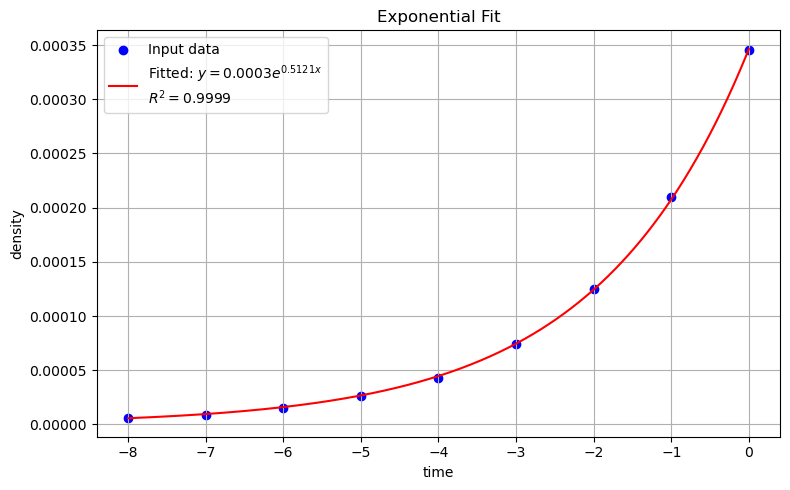

Fitted parameters: a = 0.0003465698, b = 0.5121
R-squared: 0.9999


In [118]:

# Parameters
particle_variance = 500.0 
observation_variance = 500.0 

num_particles = 250 # was 100 works with 25
num_resample = 100  # of course, things look flatter with fewer particles resampled, but still exponential.
line_length_points = np.arange(1001)
num_runs = 1000


# mix up the obervations so exponential can't be due do uncreasing the distance
# between them.
observations = [100, 500, 700, 200, 800, 300, 600, 900, 400] 
plot_steps = np.array([1,2,3,4,5,6,7,8,9])  # Plot only after these observation indices (1-based)


def gaussian(x, mean, variance):
    return norm.pdf(x, mean, np.sqrt(variance))

def compute_prior(particles, variance, line_length_points):
    prior = np.zeros_like(line_length_points, dtype=float)
    std = np.sqrt(variance)
    for center in particles:
        local_min = int(max(0, np.ceil(center - 4 * std)))
        local_max = int(min(1000, np.floor(center + 4 * std)))
        x_vals = np.arange(local_min, local_max + 1)
        g_vals = gaussian(x_vals, center, variance)
        prior[x_vals] += g_vals
    return prior / np.sum(prior)

def apply_observation(particles, obs_value, line_length_points, particle_variance, observation_variance):
    prior = compute_prior(particles, particle_variance, line_length_points)
    likelihood = gaussian(line_length_points, mean=obs_value, variance=observation_variance)
    likelihood /= np.sum(likelihood)
    posterior = prior * likelihood
    posterior /= np.sum(posterior)

    resampled = np.random.choice(line_length_points, size=num_resample, replace=True, p=posterior)
    replace_indices = np.random.choice(len(particles), size=num_resample, replace=False)
    new_particles = particles.copy()
    new_particles[replace_indices] = resampled

    return new_particles


# Run the simulation and average priors
avg_priors = [np.zeros_like(line_length_points, dtype=float) for _ in observations]
for _ in range(num_runs):
    particles = np.random.choice(line_length_points, size=num_particles, replace=False)
    for i, obs in enumerate(observations):
        particles = apply_observation(particles, obs, line_length_points, particle_variance, observation_variance)
        prior = compute_prior(particles, particle_variance, line_length_points)
        avg_priors[i] += prior

avg_priors = [p / num_runs for p in avg_priors]


first_item_density = np.zeros(len(observations))
x_vals = np.linspace(0, -8, 9) # time steps between 0 and -8

for i in range(len(observations)):
    first_item_density[i] = avg_priors[i][0]

print('x_vals',x_vals)
print('fid',first_item_density)

# Fit and plot
params, r2 = fit_exponential_curve(x_vals,first_item_density, plot=True)
print(f"Fitted parameters: a = {params[0]:.10f}, b = {params[1]:.4f}")
print(f"R-squared: {r2:.4f}")

